# Convert Tactus xml files to csv files

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import xml.etree.ElementTree as ET

In [2]:
CLIENT = "client"
COUNSELOR = "counselor"
DATADIR = "../usb/tmp/20190917/"
FILEPATTERN = "AdB.*xml.gz"

## Process tag AssignedCounselor

In [3]:
TACTUSMAIL = "alcoholdebaas@tactus.nl"
EMAIL = "Email"

def dictToString(data):
    string = ""
    for key in sorted(data.keys()):
        string += key+":"+data[key]+" "
    return(string)

def inExcludedCounselors(counselorString):
    return(not re.search(EMAIL+":",counselorString,flags=re.IGNORECASE) or \
           re.search(TACTUSMAIL,counselorString,flags=re.IGNORECASE))

def fileNameToId(fileName):
    return(fileName.split(".")[0])

def readGzippedXmlFile(inFileName):
    inFile = gzip.open(inFileName)
    inFileContent = inFile.read()
    inFile.close()
    root = ET.fromstring(inFileContent)
    return(root)

In [4]:
COUNSELORQUERY = "./AssignedCounselor"
OUTFILENAME = "AssignedCounselor.csv"

def getCounselorData():
    inFileNames = sorted(os.listdir(DATADIR))
    clientDict = {}
    counselorDict = {"":0}
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for counselor in root.findall(COUNSELORQUERY):
                counselorData = {}
                for i in range(0,len(counselor)):
                    try:
                        counselorData[counselor[i].tag.strip()] = counselor[i].text.strip()
                    except: pass
            counselorString = dictToString(counselorData)
            if not counselorString in counselorDict: counselorDict[counselorString] = len(counselorDict)
            clientDict[fileNameToId(inFileName)] = counselorDict[counselorString]
    return(clientDict,counselorDict)

In [5]:
def clientDictToCounselorDf(clientDict):
    counselorDf = pd.DataFrame(clientDict,index=[0]).T.rename(columns={0:COUNSELOR})
    counselorDf.index.name = CLIENT
    return(counselorDf)

def saveCounselorDf(counselorDf,outFileName=OUTFILENAME):
    counselorDf.to_csv(outFileName)
    
def visualizeCounselorDf(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    counselorDictT = {counselorDict[c]:c for c in counselorDict}
    x = [c for c in sorted(counselorGroups.keys()) if not inExcludedCounselors(counselorDictT[c])]
    y = [len(counselorGroups[g]) for g in x]
    plt.figure(figsize=(10,5))
    plt.bar(x,y)
    plt.xlabel("counselor id")
    plt.title(f"Number of clients per counselor (average: {round(np.average(y),1)}; standard deviation: {round(np.std(y))})")
    plt.show()
    
def showExcludedCounselors(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    for c in counselorDict:
        if inExcludedCounselors(c):
            print(f"id: {counselorDict[c]}; frequency: {len(counselorGroups[counselorDict[c]])}; data: {c}")
    

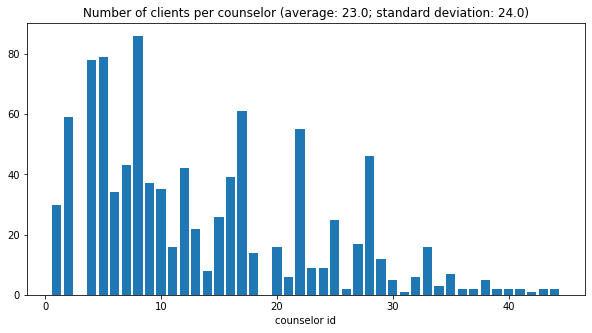

In [6]:
clientDict,counselorDict = getCounselorData()
counselorDf = clientDictToCounselorDf(clientDict)
saveCounselorDf(counselorDf,outFileName=OUTFILENAME)
visualizeCounselorDf(counselorDf,counselorDict)

In [7]:
showExcludedCounselors(counselorDf,counselorDict)

id: 0; frequency: 763; data: 
id: 3; frequency: 254; data: Email:alcoholdebaas@tactus.nl FirstName:Geen LastName:Hulpverlener 
id: 19; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Aangehouden LastName:cliënten 
id: 45; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Niet LastName:Gestart 


## Process tag Intake

In [8]:
TITLE = "title"
QUESTIONNUMBER = "questionNumber"
ANSWER = "answer"
ANSWERID = "answerId"
ANSWERTEXT = "answerText"
ANSWERTITLE = "answerTitle"
ID = "ID"
QUERYINTAKE = "./Intake"
QUERYQUESTION = ".//question"
QUERYTITLE = "./"+TITLE
QUERYQUESTIONNUMBER = "./"+QUESTIONNUMBER
QUERYANSWER = "./"+ANSWER
QUERYANSWERTEXT = "./"+ANSWERTEXT
OUTFILENAME = "Intake.csv"

In [9]:
def getAnswerDataList():
    inFileNames = sorted(os.listdir(DATADIR))
    answerDataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for intake in root.findall(QUERYINTAKE):
                for question in intake.findall(QUERYQUESTION):
                    answerDict = {CLIENT:fileNameToId(inFileName)}
                    try:
                        answerDict[TITLE] = list(question.findall(QUERYTITLE))[0].text.strip()
                    except: pass
                    try:
                        answerDict[QUESTIONNUMBER] = list(question.findall(QUERYQUESTIONNUMBER))[0].text.strip()
                    except: pass
                    for answer in question.findall(QUERYANSWER):
                        answerDictCopy = dict(answerDict)
                        answerDictCopy[ANSWERID] = answer.attrib[ID]
                        try:
                            answerDictCopy[ANSWERTEXT] = list(answer.findall(QUERYANSWERTEXT))[0].text.strip()
                        except: pass
                        try:
                            answerDictCopy[ANSWERTITLE] = list(answer.findall(QUERYTITLE))[0].text.strip()
                        except: pass
                        answerDataList.append(answerDictCopy)
    return(answerDataList)

In [10]:
DATAFREQUENCYTHRESHOLD = 5
REMOVED = "REMOVED"

def makeAnswerId(answer):
    if not QUESTIONNUMBER in answer: questionNumber = ""
    else: questionNumber = answer[QUESTIONNUMBER]
    if not ANSWERID in answer: answerId = ""
    else: answerId = answer[ANSWERID]
    return(questionNumber+"-"+answerId)

def countAnswerTexts(answerDataList):
    answerTextFreqs = {}
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        try:
            answerText = answerDataList[i][ANSWERTEXT]
        except: answerText = ""
        if not answerId in answerTextFreqs: answerTextFreqs[answerId] = {}
        if not answerText in answerTextFreqs[answerId]: answerTextFreqs[answerId][answerText] = 0
        answerTextFreqs[answerId][answerText] += 1
    return(answerTextFreqs)

def removeRareDataValues(answerDataList,answerFreqs):
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        if ANSWERTEXT in answerDataList[i] and \
           answerDataList[i][ANSWERTEXT] != "" and \
           answerFreqs[answerId][answerDataList[i][ANSWERTEXT]] < DATAFREQUENCYTHRESHOLD:
            answerDataList[i][ANSWERTEXT] = REMOVED
    return(answerDataList)

In [11]:
def answerDataListToDf(answerDataList):
    return(pd.DataFrame(answerDataList))

def saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME):
    answerDataDf.to_csv(outFileName,index=None)

In [12]:
def visualizeAnswerDataDf(answerDataDf):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    plt.figure(figsize=(16,5))
    plt.bar(x,y)
    plt.title("Number of answers per client in intake forms")
    plt.xlabel("client id")
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    plt.show()

In [13]:
def showValueFrequencies(answerDataDf):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    seen = {}
    for yValue in y:
        if not yValue in seen:
            seen[yValue] = True
            print(f"number of occurences of {yValue} is {y.count(yValue)}")

In [15]:
answerDataList = getAnswerDataList()
answerTextFreqs = countAnswerTexts(answerDataList)
answerDataList = removeRareDataValues(answerDataList,answerTextFreqs)
answerDataDf = answerDataListToDf(answerDataList)
saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME)

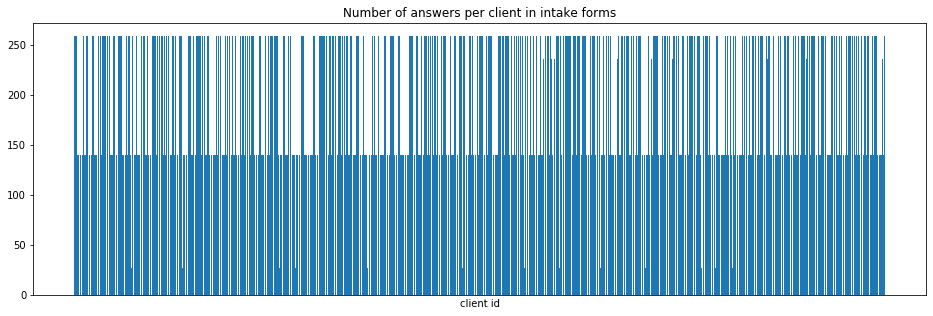

In [16]:
visualizeAnswerDataDf(answerDataDf)

In [17]:
showValueFrequencies(answerDataDf)

number of occurences of 140 is 881
number of occurences of 259 is 1014
number of occurences of 27 is 46
number of occurences of 236 is 42
